In [1]:
## importing the necessary dependencies

import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib

from obspy.geodetics.base import gps2dist_azimuth
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import tsfel

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
#from tsfresh import extract_features
#from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time

In [ ]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['font.weight'] = 'bold'

In [4]:
iq_lats = pd.read_csv('icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278

no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events)

## Below is the code for plotting missclassified earthquakes and icequakes along with their SNR and Prediction probabilities.  

## The dataset is processed. The features were extracted after - (i) Detrend, (ii) Taper of 10%, (iii) Filter of (0.5 - 25 Hz) from waveforms of 30s in the duration. 

### [ Checkout what are prediction probabilities?]

### The SNR criteria here is defined as = np.max(abs(signal))/np.std(np.abs(signal))

### Plot one example from each group of stations - [BAT, PS12, SCM, HIN]

In [454]:
def misclassified(station = 'KLU'):
    X1 = pd.read_csv(glob("/home/ak287/Icequakes_vs_Tectonicquakes/tsfel_raw_data_features/all/30s/"+station+".csv")[0])
    y1 = np.loadtxt("/home/ak287/Icequakes_vs_Tectonicquakes/tsfel_raw_data_features/all/30s/"+station+"_labels.txt")
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.33, random_state=42)

    X_train_norm = X_train.drop(columns = ['EventID'])
    X_test_norm = X_test.drop(columns = ['EventID'])

    trainedforest = RandomForestClassifier(n_estimators=100).fit(X_train_norm,y_train)

    y_predict  = trainedforest.predict(X_test_norm)
    y_proba = trainedforest.predict_proba(X_test_norm)
    ind = np.array(X_test.iloc[np.where(y_predict != y_test)[0]].index)
    print(ind)


    N_iq = len(np.where(y1 == 1)[0])-1

    miss_iq = ind[np.where(ind <= N_iq)[0]]
    miss_eq = ind[np.where(ind > N_iq)[0]]

    y_proba_iq = y_proba[:,1][np.where(y_predict != y_test)[0]][np.where(ind <= N_iq)[0]]
    y_proba_eq = y_proba[:,0][np.where(y_predict != y_test)[0]][np.where(ind > N_iq)[0]]
    
    print(miss_iq)

    miss_iq_ind = np.array(X1.iloc[miss_iq]['EventID'])
    miss_eq_ind = np.array(X1.iloc[miss_eq]['EventID'])


    file_iq = []
    file_eq = []
    for i in range(len(miss_iq_ind)):
        file_iq.append(glob('Data/icequake_waveforms/icequake'+str(miss_iq_ind[i])+'_'+station+'.mseed')[0])

    for i in range(len(miss_eq_ind)):
        file_eq.append(glob('Data/earthquake_waveforms/earthquake_'+str(miss_eq_ind[i])+'_'+station+'.mseed')[0])


    mags_iq = pd.read_csv('icequakes_catalog.csv').iloc[miss_iq_ind]['mag'].values
    mags_eq = pd.read_csv('earthquakes_catalog.csv').iloc[miss_iq_ind]['mag'].values

    depths_iq = pd.read_csv('icequakes_catalog.csv').iloc[miss_iq_ind]['depth'].values
    depths_eq = pd.read_csv('earthquakes_catalog.csv').iloc[miss_iq_ind]['depth'].values

    return file_iq, file_eq, mags_iq, mags_eq, depths_iq, depths_eq, y_proba_iq, y_proba_eq
    


[ 73 109 516  54 412 517]
[ 73 109  54]


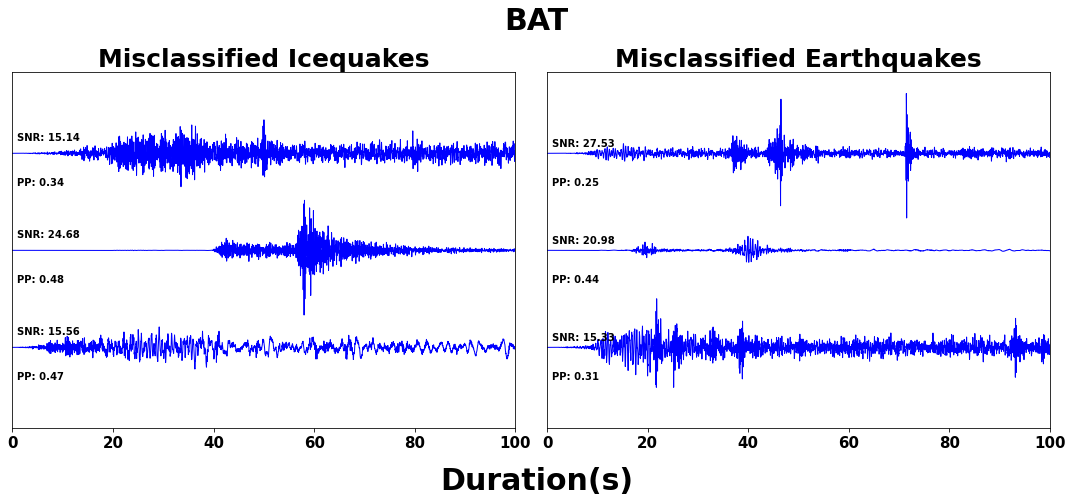

In [455]:
import warnings
warnings.filterwarnings("ignore")
fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(15,7), sharey='row', gridspec_kw=
                                                   { 'width_ratios':[1,1]})


station = 'BAT'

file_iq, file_eq, mags_iq, mags_eq, depths_iq, depths_eq, y_proba_iq, y_proba_eq = misclassified(station)
r_iq = file_iq
r_eq = file_eq

for i in range(max([len(r_iq),len(r_eq)])):
    
    try:
        st = obspy.read(r_iq[i])[0]
        st.detrend()
        st.taper(0.1)
        st.filter('bandpass', freqmin = 0.5, freqmax = 25)
        d = st.data/max(abs(st.data))
        t = st.times()
        
        snr = np.around(np.max(abs(st.data))/np.std(abs(st.data)),2)

        ax[0].plot(t, d+1.5*i, color='blue', lw = 1)
        #ax[0].text(1, 1.5*i+0.1, str('Ml: '+str(mags_iq[i])))
        ax[0].text(1, 1.5*i+0.2, str('SNR: '+str(snr)), fontweight = 'bold')
        #ax[0].text(1, 1.5*i-0.5, str('d: '+str(depths_iq[i])))
        ax[0].text(1, 1.5*i-0.5, str('PP: '+str(np.around(y_proba_iq[i],2))), fontweight = 'bold')
        
        ax[0].set_xlim(0,100)
        ax[0].set_yticks([])
        ax[0].set_title('Misclassified Icequakes', fontsize = 25, fontweight = 'bold')
        ax[0].set_xticklabels(np.arange(0,120,20),fontsize = 15, fontweight = 'bold')
    except:
        pass

for i in range(max([len(r_iq),len(r_eq)])):
    
    try:
        st = obspy.read(r_eq[i])[0]
        st.detrend()
        st.taper(0.1)
        st.filter('bandpass', freqmin = 0.5, freqmax = 25)
        d = st.data/max(abs(st.data))
        t = st.times()

        snr = np.around(np.max(abs(st.data))/np.std(abs(st.data)),2)
        ax[1].plot(t, d+1.5*i, color='blue', lw = 1)
        
        #ax[1].text(1, 1.5*i+0.1, str('Ml: '+str(mags_eq[i])))
        ax[1].text(1, 1.5*i+0.1, str('SNR: '+str(snr)), fontweight = 'bold')
        #ax[1].text(1, 1.5*i-0.5, str('d: '+str(depths_eq[i])))
        ax[1].text(1, 1.5*i-0.5, str('PP: '+str(np.around(y_proba_eq[i],2))), fontweight = 'bold')
        
        
        ax[1].set_xlim(0,100)
        ax[1].set_title('Misclassified Earthquakes', fontsize = 25, fontweight = 'bold')
        ax[1].set_xticklabels(np.arange(0,120,20),fontsize = 15, fontweight = 'bold')
    except:
        pass
    
 
fig.suptitle(station, fontsize= 30, fontweight='bold', y=0.98)
fig.supxlabel('Duration(s)',fontsize= 30, fontweight='bold')

fig.tight_layout()



## Let's plot all the earthquakes and icequakes with prediction probabilities less than 0.7

In [457]:
def misclassified(station = 'KLU'):
    X1 = pd.read_csv(glob("/home/ak287/Icequakes_vs_Tectonicquakes/tsfel_raw_data_features/all/30s/"+station+".csv")[0])
    y1 = np.loadtxt("/home/ak287/Icequakes_vs_Tectonicquakes/tsfel_raw_data_features/all/30s/"+station+"_labels.txt")
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.33, random_state=42)

    X_train_norm = X_train.drop(columns = ['EventID'])
    X_test_norm = X_test.drop(columns = ['EventID'])

    trainedforest = RandomForestClassifier(n_estimators=100).fit(X_train_norm,y_train)

    y_predict  = trainedforest.predict(X_test_norm)
    y_proba = trainedforest.predict_proba(X_test_norm)
    
    min_prob = []
    for i in range(len(y_proba)):
        min_prob.append(min(y_proba[i,0], y_proba[i,1]))
        
    ind = np.array(X_test.iloc[np.where(np.array(min_prob) > 0.3)[0]].index)
    print(ind)


    N_iq = len(np.where(y1 == 1)[0])-1

    miss_iq = ind[np.where(ind <= N_iq)[0]]
    miss_eq = ind[np.where(ind > N_iq)[0]]

    y_proba_iq = y_proba[:,1][np.where(np.array(min_prob) > 0.3)[0]][np.where(ind <= N_iq)[0]]
    y_proba_eq = y_proba[:,0][np.where(np.array(min_prob) > 0.3)[0]][np.where(ind > N_iq)[0]]
    #print(miss_iq)

    miss_iq_ind = np.array(X1.iloc[miss_iq]['EventID'])
    miss_eq_ind = np.array(X1.iloc[miss_eq]['EventID'])


    file_iq = []
    file_eq = []
    for i in range(len(miss_iq_ind)):
        file_iq.append(glob('Data/icequake_waveforms/icequake'+str(miss_iq_ind[i])+'_'+station+'.mseed')[0])

    for i in range(len(miss_eq_ind)):
        file_eq.append(glob('Data/earthquake_waveforms/earthquake_'+str(miss_eq_ind[i])+'_'+station+'.mseed')[0])


    mags_iq = pd.read_csv('icequakes_catalog.csv').iloc[miss_iq_ind]['mag'].values
    mags_eq = pd.read_csv('earthquakes_catalog.csv').iloc[miss_iq_ind]['mag'].values

    depths_iq = pd.read_csv('icequakes_catalog.csv').iloc[miss_iq_ind]['depth'].values
    depths_eq = pd.read_csv('earthquakes_catalog.csv').iloc[miss_iq_ind]['depth'].values

    return file_iq, file_eq, mags_iq, mags_eq, depths_iq, depths_eq, y_proba,  y_proba_iq, y_proba_eq
    


[3299 4236 3689 3358  969 4048 2623 4148 2707 2440 4149 3173 1293 1292 4416
 2181 1723 3612]


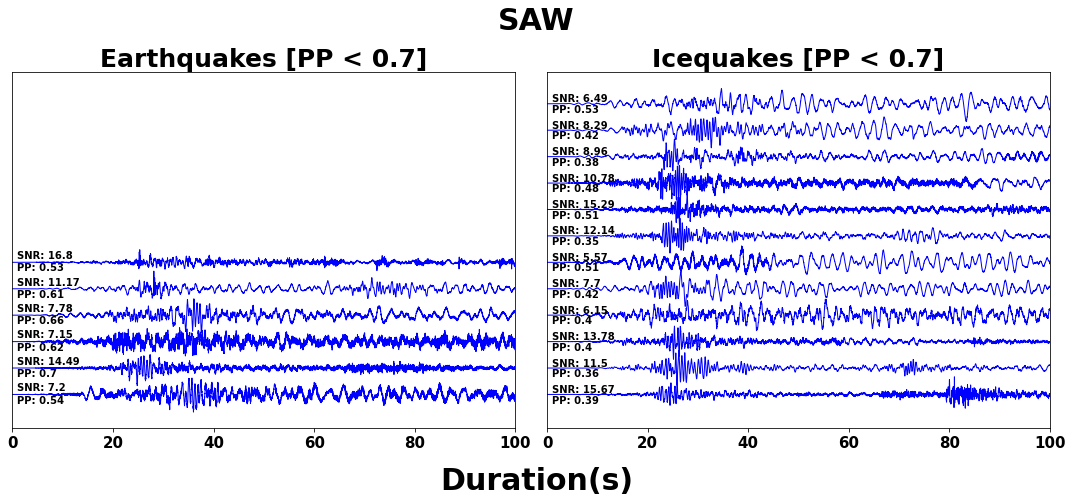

In [460]:
import warnings
warnings.filterwarnings("ignore")
fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(15,7), sharey='row', gridspec_kw=
                                                   { 'width_ratios':[1,1]})


station = 'SAW'

file_iq, file_eq, mags_iq, mags_eq, depths_iq, depths_eq, y_proba, y_proba_iq, y_proba_eq = misclassified(station)
r_iq = file_iq
r_eq = file_eq

for i in range(max([len(r_iq),len(r_eq)])):
    
    try:
        st = obspy.read(r_iq[i])[0]
        st.detrend()
        st.taper(0.1)
        st.filter('bandpass', freqmin = 0.5, freqmax = 25)
        d = st.data/max(abs(st.data))
        t = st.times()
        
        snr = np.around(np.max(abs(st.data))/np.std(abs(st.data)),2)

        ax[0].plot(t, d+1.5*i, color='blue', lw = 1)
        #ax[0].text(1, 1.5*i+0.1, str('Ml: '+str(mags_iq[i])))
        ax[0].text(1, 1.5*i+0.2, str('SNR: '+str(snr)), fontweight = 'bold')
        #ax[0].text(1, 1.5*i-0.5, str('d: '+str(depths_iq[i])))
        ax[0].text(1, 1.5*i-0.5, str('PP: '+str(np.around(y_proba_iq[i],2))), fontweight = 'bold')
        
        ax[0].set_xlim(0,100)
        ax[0].set_yticks([])
        ax[0].set_title('Earthquakes [PP < 0.7]', fontsize = 25, fontweight = 'bold')
        ax[0].set_xticklabels(np.arange(0,120,20),fontsize = 15, fontweight = 'bold')
    except:
        pass

for i in range(max([len(r_iq),len(r_eq)])):
    
    try:
        st = obspy.read(r_eq[i])[0]
        st.detrend()
        st.taper(0.1)
        st.filter('bandpass', freqmin = 0.5, freqmax = 25)
        d = st.data/max(abs(st.data))
        t = st.times()

        snr = np.around(np.max(abs(st.data))/np.std(abs(st.data)),2)
        ax[1].plot(t, d+1.5*i, color='blue', lw = 1)
        
        #ax[1].text(1, 1.5*i+0.1, str('Ml: '+str(mags_eq[i])))
        ax[1].text(1, 1.5*i+0.1, str('SNR: '+str(snr)), fontweight = 'bold')
        #ax[1].text(1, 1.5*i-0.5, str('d: '+str(depths_eq[i])))
        ax[1].text(1, 1.5*i-0.5, str('PP: '+str(np.around(y_proba_eq[i],2))), fontweight = 'bold')
        
        
        ax[1].set_xlim(0,100)
        ax[1].set_title('Icequakes [PP < 0.7]', fontsize = 25, fontweight = 'bold')
        ax[1].set_xticklabels(np.arange(0,120,20),fontsize = 15, fontweight = 'bold')
    except:
        pass
    
 
fig.suptitle(station, fontsize= 30, fontweight='bold', y=0.98)
fig.supxlabel('Duration(s)',fontsize= 30, fontweight='bold')

fig.tight_layout()

